# Start of the work

In [ ]:
# pip install opencv-python

In [ ]:
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/project/

Mounted at /content/drive
/content/drive/MyDrive/project


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## dataframe

In [ ]:
images_path = []
annotations_path = []

for dirname, _, filenames in os.walk('./archive'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        if file_path[-3:] == 'xml':
            annotations_path.append(file_path)
        else:
            images_path.append(file_path)

In [ ]:
import xml.etree.ElementTree as ET

df = pd.DataFrame(columns=['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

for xml_file in annotations_path:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    file_name = root.find('filename').text
    for obj in root.findall('object'):
        row = {
            'file_name': file_name,
            'label': obj.find('name').text,
            'xmin': int(obj.find('bndbox').find('xmin').text),
            'ymin': int(obj.find('bndbox').find('ymin').text),
            'xmax': int(obj.find('bndbox').find('xmax').text),
            'ymax': int(obj.find('bndbox').find('ymax').text)
        }
        df = df.append(row, ignore_index=True)

In [ ]:
df

,file_name,label,xmin,ymin,xmax,ymax
0,maksssksksss105.png,with_mask,178,143,213,202
1,maksssksksss105.png,with_mask,280,103,312,145
2,maksssksksss105.png,with_mask,320,79,352,119
3,maksssksksss105.png,with_mask,365,53,390,84
4,maksssksksss105.png,with_mask,243,36,267,67
...,...,...,...,...,...,...
4067,maksssksksss495.png,with_mask,224,70,267,121
4068,maksssksksss495.png,without_mask,274,61,330,122
4069,maksssksksss495.png,with_mask,291,189,356,224
4070,maksssksksss495.png,with_mask,329,117,388,181


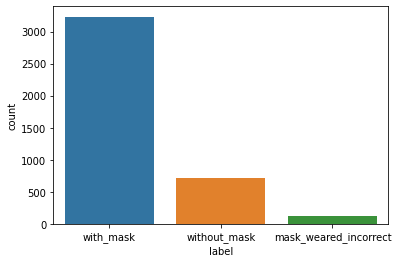

In [ ]:
sns.countplot(x=df.label)

In [ ]:
df.label.value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: label, dtype: int64

## save image

In [ ]:
input_data_path = './archive/images'
annotations_path = "./archive/annotations"
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'
import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

from PIL import Image
def crop_img(image_path, xmin, ymin, xmax, ymax):
    x_shift = (xmax - xmin) * 0.1
    y_shift = (ymax - ymin) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((xmin - x_shift, ymin - y_shift, xmax + x_shift, ymax + y_shift))
    return cropped

def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name][['label', 'xmin', 'ymin', 'xmax', 'ymax']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        label, xmin, ymin, xmax, ymax = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, xmin, ymin, xmax, ymax), label,f'{image_name[:-4]}_{(xmin, ymin)}'))
    return faces

def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

images = [*os.listdir("./archive/images")]
cropped_faces = [extract_faces(img, df) for img in images]
flat_cropped_faces = sum(cropped_faces, [])
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [ ]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=36)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=36)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=36)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=36)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=36)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=36)


In [ ]:
output_data_path =  '.'
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


## load data

In [ ]:
Batch_size = 128
train_folder = 'train'
valid_folder = 'val'
test_folder = 'test'

data_transforms_test = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_folder, transform=data_transforms)
valid_data = datasets.ImageFolder(valid_folder, transform=data_transforms_test)
test_data = datasets.ImageFolder(test_folder, transform=data_transforms_test)

len(train_data)
len(valid_data)
len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=Batch_size, shuffle=True,num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=Batch_size, shuffle=False,num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=Batch_size, shuffle=False,num_workers=0)

# Model

## pre model work

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
def evaluate_accuracy(test_iter, net, device=device):
    pred_all = []
    label_all = []
    metric = [0, 0]
    with torch.no_grad():
        for X, y in test_iter:
            net.eval()
            X = X.to(device)
            y = y.to(device)
            net = net.to(device)
            y_hat = net(X)
            metric[0] += (y_hat.argmax(dim=1) == y).sum().item()
            metric[1] += len(y)
            pred_all.extend(y_hat.argmax(dim=1).cpu())
            label_all.extend(y.cpu())
            l_loss = loss(y_hat, y)
            
        precision = precision_score(label_all,pred_all,average='macro')
        recall = recall_score(label_all,pred_all,average='macro')
        f1 = f1_score(label_all,pred_all,average='macro')
            
    return l_loss.item(), metric[0]/metric[1], precision, recall, f1

def metricss(y_true, y_pred):
    pre = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return {'1pre': pre,'2recall': recall,'3f1': f1}

def plot_metricss():
  # plt.plot(training_history["epoch"], training_history["train_loss"])
  # plt.plot(training_history["epoch"], training_history["test_loss"])
  # plt.plot(training_history["epoch"], training_history["train_accuracy"])
  # plt.plot(training_history["epoch"], training_history["test_accuracy"])

  # plt.xlabel("number of epochs")
  # plt.ylabel("objective function")
  # plt.legend(["train_loss","test_loss","train_accuracy", "test_accuracy"])

    history_df = pd.DataFrame(training_history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['train_loss', 'test_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['train_accuracy', 'test_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

In [ ]:
def train(model):
  since = time.time()
  for epoch in range(num_epochs):
      metric = [0, 0, 0]
      model.train()
      total_y, total_pred_label = [], []
      
      for X, y in train_loader:
          X = X.to(device)
          y = y.to(device)
          y_hat = model(X)
          l = loss(y_hat, y)
          optimizer.zero_grad()
          l.backward()
          optimizer.step()
          metric[0] += l.item()*len(y)
          metric[1] += (y_hat.argmax(dim=1) == y).sum().item()
          metric[2] += len(y)
          
          total_y.extend(y.cpu())
          total_pred_label.extend(y_hat.argmax(dim=1).cpu())

      with torch.no_grad():
          train_l = metric[0]/metric[2]
          train_acc = metric[1]/metric[2]
          test_l, test_acc, test_pre,test_recall,test_f1 = evaluate_accuracy(valid_loader, model, device)
      
          metric_score = metricss(np.array(total_y), np.array(total_pred_label))
          sorted_metric_score = sorted(metric_score.items(), key=lambda x: x[0])
          metrics_string = '\t'.join(['loss'] +['acc']+ [metric_name[1:] for metric_name, _ in sorted_metric_score])
          score_string = '\t'.join(['{:.4f}'.format(train_l)] + ['{:.4f}'.format(train_acc)]+['{:.4f}'.format(score) for _, score in sorted_metric_score])
          print("{}{}\t{}".format('epoch', epoch, metrics_string))
          print("{}{}\t{}".format('train', '', score_string))

          training_history["train_loss"].append(train_l)
          training_history["train_accuracy"].append(train_acc)    
          training_history["epoch"].append(epoch)
          training_history["test_loss"].append(test_l)
          training_history["test_accuracy"].append(test_acc)
          print("{}{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format('test', '', test_l, test_acc, test_pre, test_recall, test_f1))  

  time_elapsed = time.time() - since
  print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

## CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        #you may need to change the numbers when given an input of different dimensions
        self.fc1 = nn.Linear(774400, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
num_epochs = 5
model = CNN(3,3).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
train(model)

epoch0	loss	acc	pre	recall	f1
train	0.5865	0.7749	0.4495	0.3971	0.4088
test	1.8851	0.7920	0.2640	0.3333	0.2946
epoch1	loss	acc	pre	recall	f1
train	0.3758	0.8695	0.5363	0.5421	0.5390
test	1.4476	0.7920	0.2640	0.3333	0.2946
epoch2	loss	acc	pre	recall	f1
train	0.3692	0.8787	0.5415	0.5595	0.5504
test	3.1438	0.7920	0.2640	0.3333	0.2946
epoch3	loss	acc	pre	recall	f1
train	0.3616	0.8876	0.5526	0.5692	0.5608
test	4.0044	0.7972	0.5987	0.3432	0.3147
epoch4	loss	acc	pre	recall	f1
train	0.3518	0.8805	0.5438	0.5648	0.5541
test	3.8600	0.7920	0.2640	0.3333	0.2946
Training completed in 1m 51s


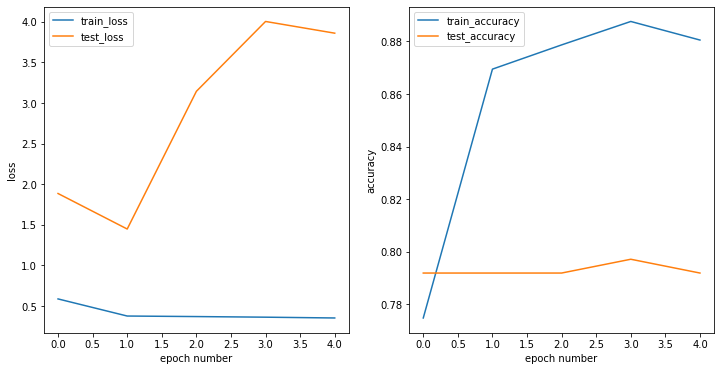

In [ ]:
plot_metricss()

## Densnet161

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad=True
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, 3)
model.classifier.out_features = last_layer

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
num_epochs = 5
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
train(model)

OutOfMemoryError: ignored

In [ ]:
plot_metricss()

## Alexnet

In [ ]:
model = models.alexnet(pretrained=True)
num_ftrs = model.classifier[-1].in_features 
model.classifier[-1] = nn.Linear(num_ftrs, 3)
model = model.to(device)

In [ ]:
num_epochs = 5
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
train(model)

epoch0	loss	acc	pre	recall	f1
train	0.5024	0.8415	0.5301	0.4902	0.5028
test	1.8180	0.8024	0.5104	0.3583	0.3441
epoch1	loss	acc	pre	recall	f1
train	0.3112	0.8928	0.5595	0.5745	0.5669
test	0.9650	0.7797	0.3929	0.3590	0.3515
epoch2	loss	acc	pre	recall	f1
train	0.2880	0.9002	0.7735	0.6030	0.6068
test	3.2973	0.8007	0.5524	0.3524	0.3330
epoch3	loss	acc	pre	recall	f1
train	0.2522	0.9109	0.8360	0.6294	0.6474
test	3.1119	0.8024	0.5588	0.3557	0.3391
epoch4	loss	acc	pre	recall	f1
train	0.2455	0.9201	0.8380	0.6481	0.6761
test	2.6138	0.8024	0.5104	0.3583	0.3441
Training completed in 1m 11s


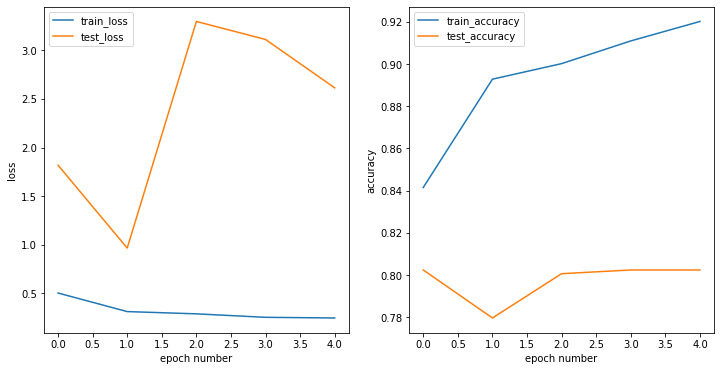

In [ ]:
plot_metricss()

## ResNet

In [ ]:
model=models.resnet34(pretrained=True)
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)
model.fc.out_features=last_layer

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
num_epochs = 5
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
train(model)

epoch0	loss	acc	pre	recall	f1
train	1.3227	0.7973	0.0081	0.0075	0.0078
test	7.3001	0.7937	0.5978	0.3366	0.3015
epoch1	loss	acc	pre	recall	f1
train	0.3075	0.9017	0.7195	0.6374	0.6581
test	1.2361	0.7937	0.4402	0.3956	0.4008
epoch2	loss	acc	pre	recall	f1
train	0.2177	0.9251	0.8230	0.7008	0.7285
test	3.1206	0.8007	0.5996	0.3498	0.3275
epoch3	loss	acc	pre	recall	f1
train	0.2168	0.9272	0.8244	0.7037	0.7368
test	2.8627	0.7990	0.5992	0.3465	0.3212
epoch4	loss	acc	pre	recall	f1
train	0.1957	0.9312	0.8585	0.7230	0.7596
test	4.0350	0.7990	0.5992	0.3465	0.3212
Training completed in 4m 10s


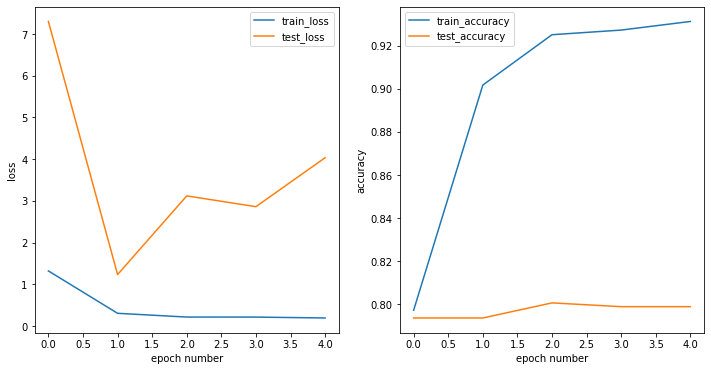

In [ ]:
plot_metricss()

# solution 1 : Data augmentation

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

In [ ]:
batch_size = 8
epochs = 50

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = datagen.flow_from_directory(
    directory='./train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory='./val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

test_generator = val_datagen.flow_from_directory(
    directory='./test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3256 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 244 images belonging to 3 classes.


In [ ]:
data_size = len(train_generator) 
steps_per_epoch = int(data_size / batch_size)
val_steps = int(len(val_generator) // batch_size)

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50
50/50 [==============================] - 2s 29ms/step - loss: 0.5940 - accuracy: 0.7925 - recall: 0.7725 - precision: 0.8089 - auc: 0.9044 - val_loss: 0.5492 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8429 - val_auc: 0.9190 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 21ms/step - loss: 0.4626 - accuracy: 0.8075 - recall: 0.7725 - precision: 0.8443 - auc: 0.9451 - val_loss: 0.3262 - val_accuracy: 0.9167 - val_recall: 0.8194 - val_precision: 0.9365 - val_auc: 0.9758 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 21ms/step - loss: 0.4147 - accuracy: 0.8775 - recall: 0.8350 - precision: 0.8883 - auc: 0.9539 - val_loss: 0.3892 - val_accuracy: 0.8750 - val_recall: 0.8472 - val_precision: 0.8714 - val_auc: 0.9575 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 20ms/step - loss: 0.2913 - accuracy: 0.9300 - recall: 0.9250 - precision: 0.9391 - auc: 0.9765 - val_loss: 0.2494 - val_accuracy: 0.9306 - va

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

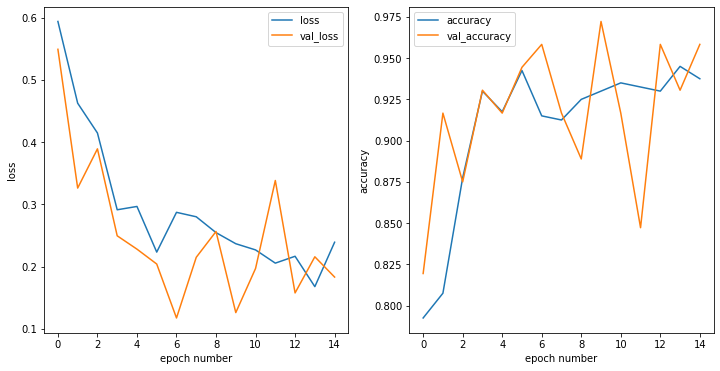

In [ ]:
plot_loss_and_accuracy(model_history.history)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat,average='micro')
    recall = recall_score(y, y_hat,average='micro')
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat,average='micro')
    report = classification_report(y,y_hat)
    print(report)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.96      0.99      0.98       194
           2       0.91      0.95      0.93        43

    accuracy                           0.95       244
   macro avg       0.63      0.65      0.64       244
weighted avg       0.93      0.95      0.94       244

Recall:  0.9549180327868853
Accuracy:  0.9549180327868853
Precision:  0.9549180327868853
F1:  0.9549180327868853


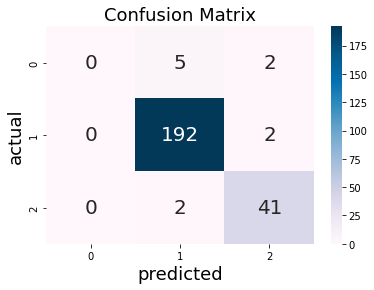

In [ ]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

In [ ]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps
)

Epoch 1/50
50/50 [==============================] - 2s 29ms/step - loss: 0.5104 - accuracy: 0.8075 - recall: 0.7725 - precision: 0.8218 - auc: 0.9301 - val_loss: 0.7585 - val_accuracy: 0.7222 - val_recall: 0.6944 - val_precision: 0.7463 - val_auc: 0.9009
Epoch 2/50
50/50 [==============================] - 1s 22ms/step - loss: 0.3165 - accuracy: 0.9075 - recall: 0.8950 - precision: 0.9203 - auc: 0.9722 - val_loss: 0.2230 - val_accuracy: 0.9444 - val_recall: 0.9444 - val_precision: 0.9444 - val_auc: 0.9868
Epoch 3/50
50/50 [==============================] - 1s 20ms/step - loss: 0.3459 - accuracy: 0.8975 - recall: 0.8875 - precision: 0.9103 - auc: 0.9641 - val_loss: 0.1801 - val_accuracy: 0.9583 - val_recall: 0.9583 - val_precision: 0.9583 - val_auc: 0.9906
Epoch 4/50
50/50 [==============================] - 1s 21ms/step - loss: 0.2781 - accuracy: 0.9150 - recall: 0.9125 - precision: 0.9241 - auc: 0.9791 - val_loss: 0.2455 - val_accuracy: 0.9583 - val_recall: 0.9583 - val_precision: 0.971

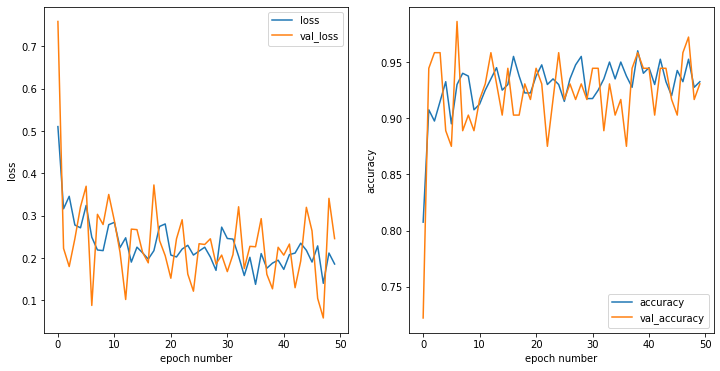

In [ ]:
plot_loss_and_accuracy(model_history.history)

31/31 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.99      0.96      0.97       194
           2       0.81      1.00      0.90        43

    accuracy                           0.95       244
   macro avg       0.93      0.80      0.82       244
weighted avg       0.96      0.95      0.95       244

Recall:  0.9508196721311475
Accuracy:  0.9508196721311475
Precision:  0.9508196721311475
F1:  0.9508196721311475


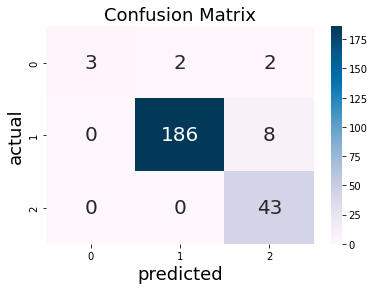

In [ ]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

# solution2 : Convert to binary class problem

## solution2 data preprocessing

### save image

In [ ]:
input_data_path = './archive/images'
annotations_path = "./archive/annotations"
#labels = df['label'].unique()
labels = ['with_mask', 'without_mask']
directory = ['train', 'test']
output_data_path =  './solution2'
import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

from PIL import Image
def crop_img(image_path, xmin, ymin, xmax, ymax):
    x_shift = (xmax - xmin) * 0.1
    y_shift = (ymax - ymin) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((xmin - x_shift, ymin - y_shift, xmax + x_shift, ymax + y_shift))
    return cropped

def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name][['label', 'xmin', 'ymin', 'xmax', 'ymax']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        label, xmin, ymin, xmax, ymax = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, xmin, ymin, xmax, ymax), label,f'{image_name[:-4]}_{(xmin, ymin)}'))
    return faces

def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

images = [*os.listdir("./archive/images")]
cropped_faces = [extract_faces(img, df) for img in images]
flat_cropped_faces = sum(cropped_faces, [])
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [ ]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=712)
train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=712)

In [ ]:
output_data_path =  './solution2'
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')


for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    

### loead data

In [ ]:
Batch_size = 128
train_folder = './solution2/train'
test_folder = './solution2/test'

data_transforms_test = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_folder, transform=data_transforms)
test_data = datasets.ImageFolder(test_folder, transform=data_transforms_test)

len(train_data)
len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=Batch_size, shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=Batch_size, shuffle=False,num_workers=0)

## solution2 alexnet transfer learning

In [ ]:
import torchvision.models as models
model_ft = models.alexnet(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_ft = model_ft.to(device)

In [ ]:
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 1) 
model_ft = model_ft.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=1e-5, momentum=0.9)

In [ ]:
from pandas.core.groupby.groupby import OutputFrameOrSeries
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        train_epoch_loss = 0
        correct_train = 0
        total_train = len(train_data)
        for images, labels in tqdm(train_loader):

            inputs = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Do the forward pass
            outputs = model(inputs)
            predictions_train = torch.round(torch.sigmoid(outputs)).long()
            correct_train += torch.sum((predictions_train == labels).float())
            loss = criterion(outputs, labels)

            # Calculate gradients and step
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        training_history["train_accuracy"].append((correct_train/total_train).cpu().numpy().astype(float))
        training_history["train_loss"].append(train_epoch_loss)
        training_history["epoch"].append(epoch)
        test_model()
        model_ft.train() # set model back to training mode (batch norm layers back to normal) after testing
        
        
def test_model():
    ## Testing
    correct = 0
    total = len(test_data)
    test_epoch_loss = 0
    model_ft.eval() # set the model into evaluation mode, which changes the 
    # behavior of the batch norm layer so that it is not sensitive to batch size
    with torch.no_grad():
        # Iterate through test set minibatchs 
        for images, labels in tqdm(test_loader):
            # Forward pass
            inputs = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            y = model_ft(inputs)
            loss = criterion(y, labels.float())
            test_epoch_loss += loss.item()

            predictions = torch.round(torch.sigmoid(y)).long()
            correct += torch.sum((predictions == labels).float())
    print('Test accuracy: {}'.format(correct/total))
    training_history["test_accuracy"].append((correct/total).cpu().numpy().astype(float))
    training_history["test_loss"].append(test_epoch_loss)


In [ ]:
# train_accuracy = []
# test_accuracy = []
# train_loss = []
# test_loss = []
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
num_epochs=5
train_model(model_ft, criterion, optimizer, num_epochs)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.6295828223228455


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.7673830986022949


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.7888748645782471


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.795195996761322


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.7989886403083801


[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'epoch number')]

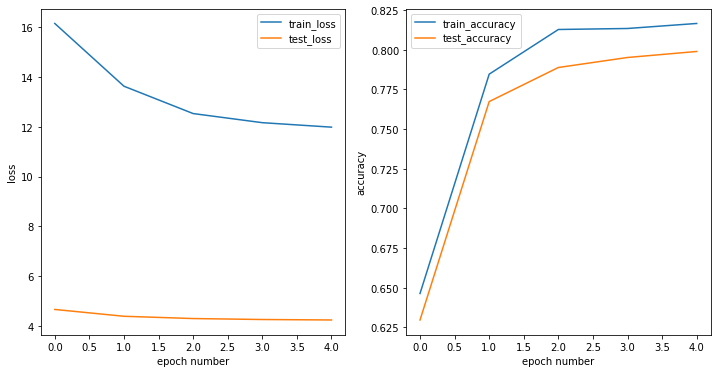

In [ ]:
history_df = pd.DataFrame(training_history)
# history_df.train_accuracy = pd.to_numeric(history_df.train_accuracy)
# history_df.test_accuracy = pd.to_numeric(history_df.test_accuracy)
history_df["train_accuracy"]=history_df["train_accuracy"].astype(float)
history_df["test_accuracy"]=history_df["test_accuracy"].astype(float)
fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
history_df.loc[0:, ['train_loss', 'test_loss']].plot(ax=ax[0])
ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

history_df.loc[0:, ['train_accuracy', 'test_accuracy']].plot(ax=ax[1])
ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    report = classification_report(y,y_hat)
    print(report)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       647
         1.0       0.18      0.04      0.07       144

    accuracy                           0.79       791
   macro avg       0.50      0.50      0.47       791
weighted avg       0.70      0.79      0.73       791

Recall:  0.041666666666666664
Accuracy:  0.7901390644753477
Precision:  0.17647058823529413
F1:  0.06741573033707865


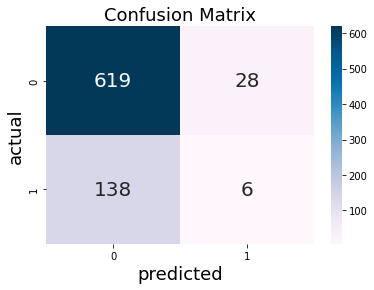

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model_ft(inputs) # Feed Network

        output = torch.round(torch.sigmoid(outputs)).long()
        y_pred.extend(output.cpu().numpy()) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

evaluation(y_true, y_pred)
# # constant for classes
# classes = ('with_mask', 'without_mask')

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)



# Solution3: Freezing layers in transfer learning

## Data preprocessing

In [ ]:
Batch_size = 128
train_folder = 'train'
valid_folder = 'val'
test_folder = 'test'

data_transforms_test = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_folder, transform=data_transforms)
valid_data = datasets.ImageFolder(valid_folder, transform=data_transforms_test)
test_data = datasets.ImageFolder(test_folder, transform=data_transforms_test)

len(train_data)
len(valid_data)
len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=Batch_size, shuffle=True,num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=Batch_size, shuffle=False,num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=Batch_size, shuffle=False,num_workers=0)

## Model

In [ ]:
def train(model):
  since = time.time()
  for epoch in range(num_epochs):
      metric = [0, 0, 0]
      model.train()
      total_y, total_pred_label = [], []
      
      for X, y in train_loader:
          X = X.to(device)
          y = y.to(device)
          y_hat = model(X)
          l = loss(y_hat, y)
          optimizer.zero_grad()
          l.backward()
          optimizer.step()
          metric[0] += l.item()*len(y)
          metric[1] += (y_hat.argmax(dim=1) == y).sum().item()
          metric[2] += len(y)
          
          total_y.extend(y.cpu())
          total_pred_label.extend(y_hat.argmax(dim=1).cpu())

      with torch.no_grad():
          train_l = metric[0]/metric[2]
          train_acc = metric[1]/metric[2]
          test_l, test_acc, test_pre,test_recall,test_f1 = evaluate_accuracy(valid_loader, model, device)
      
          metric_score = metricss(np.array(total_y), np.array(total_pred_label))
          sorted_metric_score = sorted(metric_score.items(), key=lambda x: x[0])
          metrics_string = '\t'.join(['loss'] +['acc']+ [metric_name[1:] for metric_name, _ in sorted_metric_score])
          score_string = '\t'.join(['{:.4f}'.format(train_l)] + ['{:.4f}'.format(train_acc)]+['{:.4f}'.format(score) for _, score in sorted_metric_score])
          print("{}{}\t{}".format('epoch', epoch, metrics_string))
          print("{}{}\t{}".format('train', '', score_string))

          training_history["train_loss"].append(train_l)
          training_history["train_accuracy"].append(train_acc)    
          training_history["epoch"].append(epoch)
          training_history["test_loss"].append(test_l)
          training_history["test_accuracy"].append(test_acc)
          print("{}{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format('test', '', test_l, test_acc, test_pre, test_recall, test_f1))  

  time_elapsed = time.time() - since
  print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
model_ft = models.alexnet(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier[-1].in_features 
model_ft.classifier[-1] = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)
model = model_ft.to(device)
optimizer = torch.optim.SGD(model_ft.parameters(), lr=1e-5, momentum=0.9)

In [ ]:
num_epochs = 5
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7)
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
train(model)

epoch0	loss	acc	pre	recall	f1
train	0.6889	0.7770	0.4285	0.4385	0.4334
test	2.2311	0.7990	0.5992	0.3465	0.3212
epoch1	loss	acc	pre	recall	f1
train	0.4375	0.8452	0.8434	0.5057	0.5118
test	3.5886	0.8024	0.6001	0.3531	0.3338
epoch2	loss	acc	pre	recall	f1
train	0.4041	0.8538	0.8566	0.5094	0.5191
test	2.5556	0.8042	0.6006	0.3564	0.3399
epoch3	loss	acc	pre	recall	f1
train	0.3900	0.8526	0.6036	0.5174	0.5227
test	3.2832	0.8007	0.5996	0.3498	0.3275
epoch4	loss	acc	pre	recall	f1
train	0.3792	0.8590	0.6105	0.5192	0.5266
test	3.5329	0.8024	0.6001	0.3531	0.3338
Training completed in 1m 5s


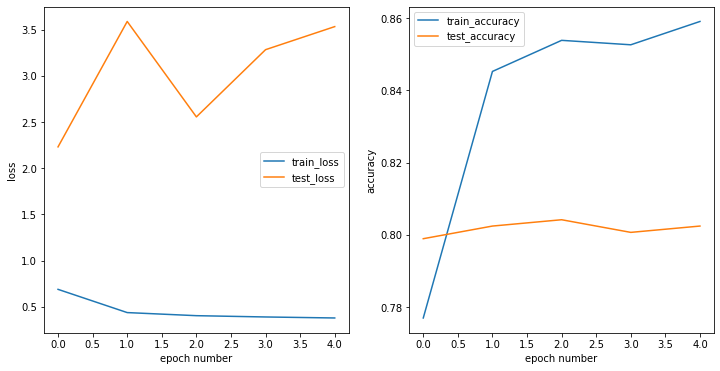

In [ ]:
plot_metricss()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat,average='micro')
    recall = recall_score(y, y_hat,average='micro')
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat,average='micro')
    report = classification_report(y,y_hat)
    print(report)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.80      1.00      0.89       194
           2       1.00      0.02      0.05        43

    accuracy                           0.80       244
   macro avg       0.60      0.34      0.31       244
weighted avg       0.81      0.80      0.71       244

Recall:  0.7991803278688525
Accuracy:  0.7991803278688525
Precision:  0.7991803278688525
F1:  0.7991803278688525


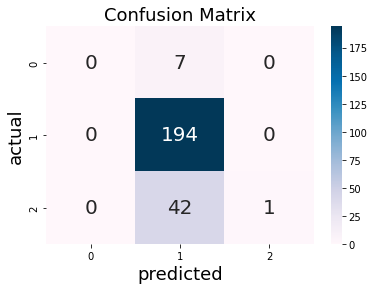

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).argmax(axis=1) # Feed Network
        y_pred.extend(outputs.cpu().numpy()) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

evaluation(y_true, y_pred)